# Модель для классификации комментариев для интернет-магазина "Викишоп"

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. В вашем распоряжении набор данных с разметкой о токсичности правок.

**Цель** - обучить модель классифицировать комментарии на позитивные и негативные. Построить модель со значением метрики качества F1 не меньше 0.75.

# Предобработка

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords

import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

import itertools # для демонстрации случайных элементов из объекта типа set

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Slava\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Slava\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Slava\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Загрузка и подготовка данных
Столбец `text` в нём содержит текст комментария, а `toxic` — целевой признак.

Загрузим данные:

In [4]:
path = ''
df = pd.read_csv(path + 'toxic_comments.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Проверим на дубликаты на всякий случай:

In [5]:
df.duplicated().sum()

0

Проверим баланс классов:

0    0.898321
1    0.101679
Name: toxic, dtype: float64

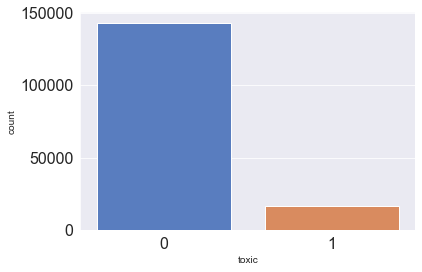

In [6]:
sns.countplot(df['toxic'])
df['toxic'].value_counts(normalize=True)

In [7]:
df.query('toxic == 1').sample(5)

,text,toxic
78759,You been cryin Tasc0? Bout time they BLOCKED y...,1
31798,"""\n\n Admin \n\n""""I saw you were made admin an...",1
107592,"JzG\n\nWrong is still wrong, the circumstances...",1
109206,"""\n\nOk, now I really don't understand you. Yo...",1
66741,==ChrisO Internet Vandal and Criminal==\nChris...,1


**По этому этапу можно сказать, что пропусков и дубликатов в датафрейме нет. Также нет и баланса классов, почти 90% комментариев нетоксичные, остальные 10% весьма toxic (отдельный привет Britney Spears =)**

## Чистка текста

In [8]:
def clear_text(text):
    """Оставляет только латинские буквы, очищая текст от цифр и 
    служебных символов типа \n """
    text = text.lower()
    # все что не текст или кавычка в тексте (например I'm) заменяем на пробел
    clear_text = re.sub(r'[^a-zA-z]', ' ', text) 
    clear_text = clear_text.split()
    clear_text = ' '.join(clear_text)
    return clear_text

In [9]:
df['text_cleared'] = df['text'].apply(clear_text)
df.head(10)

,text,toxic,text_cleared
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...
5,"""\n\nCongratulations from me as well, use the ...",0,congratulations from me as well use the tools ...
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker before you piss around on my work
7,Your vandalism to the Matt Shirvington article...,0,your vandalism to the matt shirvington article...
8,Sorry if the word 'nonsense' was offensive to ...,0,sorry if the word nonsense was offensive to yo...
9,alignment on this subject and which are contra...,0,alignment on this subject and which are contra...


## Лемматизация

Применим лемматизацию для английского языка, как это сделать [инфу брал здесь](https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/). Сначала инициализируем Wordnet Lemmatizer:

In [10]:
lemmatizer = WordNetLemmatizer()

Разобъем преложение на слова с помощью nltk.word_tokenize, а затем каждое слово лемматизируем:

In [11]:
def lemmatize(text):
    """Возвращает строку из лемм исходных слов"""
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join(
                            [lemmatizer.lemmatize(word) for word in word_list])
    return lemmatized_output

In [12]:
%%time
df['text_lemm'] = df['text_cleared'].apply(lemmatize)

Wall time: 1min 38s


Разделим на обучающую и тестовую выборки в пропорции 70:30%. Здесь почему-то странно, используя `stratify=df['toxic']`, метрика получалась на 0.2-0.4 хуже, поэтому убрал.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df['text_lemm'], 
                                                    df['toxic'],
                                                    test_size=0.30,
                                                    random_state=123)

Создадим корпус комментариев, используем кодировку Unicode:

In [14]:
corpus_train = X_train.values.astype('U')
corpus_test = X_test.values.astype('U')

print("Длина обучающего корпуса:", len(corpus_train))
print("Длина тестового корпуса:", len(corpus_test))

Длина обучающего корпуса: 111699
Длина тестового корпуса: 47872


# Обучение

In [15]:
def my_lr_model(X_train, y_train, 
                X_test, y_test, 
                class_weight):
    """Задает алгоритм логистической регрессии с возможностью взвесить классы и
    разными значениями порога threshold, а также отображает график f1 и auc метрик."""
    threshold_list = []
    f1_score_list = []
    roc_auc_list = []
    # сделаем прогноз с разными порогами
    for threshold in np.arange(0, 1, 0.05):
        lr_model = LogisticRegression(random_state=12345,
                                      solver='liblinear', 
                                      class_weight=class_weight)
        lr_model.fit(X_train, y_train)
        # воспользуемся уже обученной моделью, чтобы определить вероятности для "0" и "1"
        proba_test = lr_model.predict_proba(X_test)
        # вероятности для класса "1"
        proba_1_test = proba_test[:, 1]
        # откорректируем прогноз по порогу   
        predict_test = np.where(proba_1_test > threshold, 1, 0)
        f1 = f1_score(y_test, predict_test)
        roc_auc = roc_auc_score(y_test, proba_1_test)
        # сохраним значения метрик 
        threshold_list.append(threshold)
        f1_score_list.append(f1)
        roc_auc_list.append(roc_auc)
        lr_model_result = pd.DataFrame({'threshold':threshold_list, 
                                       'f1_value':f1_score_list, 
                                       'roc_auc_value':roc_auc_list})
        
    # посмотрим графически
    ax = lr_model_result.plot(x="threshold", y="f1_value", legend=False, 
                              marker='.', linestyle='', color='b')
    ax2 = ax.twinx()
    lr_model_result.plot(x="threshold", y="roc_auc_value", ax=ax2, legend=False,
                         marker='.', linestyle='-', color='g')
    ax.figure.legend(loc='center', fontsize=16)
    plt.show()
    
    display(lr_model_result
     .sort_values(by='f1_value', ascending=False)
     .head(10)
     .style
     .format('{:.3f}', subset=['f1_value', 'roc_auc_value'])
     .highlight_max(subset=['f1_value', 'roc_auc_value'])
    )

## TF-IDF без N-грамм

Подгрузим английский стоп-слова (слова не несущие смысловой нагрузки):

In [16]:
stopwords = set(nltk_stopwords.words('english'))

Пример 20 английских стоп-слов:

In [17]:
print(set(itertools.islice(stopwords, 20)), end='')

{'won', 'wouldn', "that'll", 'or', 'to', 'isn', 'did', 'wasn', 'under', 've', 'who', "wasn't", 'theirs', 'same', 'my', 'between', 'their', 's', 'off', 'you'}

Создадим счётчик, указав в нем стоп-слова:

In [18]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

Вычислим TF-IDF для имеющегося корпуса текстов, полученные матрицы `tf_idf` далее используем как матрицы-признаков:

In [19]:
%%time
tf_idf_train = count_tf_idf.fit_transform(corpus_train) # fit только на обучающей!
tf_idf_test = count_tf_idf.transform(corpus_test)

Wall time: 9.89 s


In [20]:
print("Размер матрицы признаков:", tf_idf_train.shape)
print("Размер целевой переменной:", y_train.shape)

Размер матрицы признаков: (111699, 130833)
Размер целевой переменной: (111699,)


In [21]:
print("Размер матрицы признаков:", tf_idf_test.shape)
print("Размер целевой переменной:", y_test.shape)

Размер матрицы признаков: (47872, 130833)
Размер целевой переменной: (47872,)


Посмотрим на признаки-токены:

In [22]:
feature_dict = count_tf_idf.vocabulary_

feature_dict = (pd.DataFrame.from_dict(feature_dict, 
                                      orient='index', 
                                      columns=['feature_number'])
                            .sort_values(by='feature_number')
               )
feature_dict

,feature_number
__,0
___,1
____,2
_____,3
______,4
...,...
zzzzzzz,130828
zzzzzzzzzzzzzzzzz,130829
zzzzzzzzzzzzzzzzzzzzz,130830
zzzzzzzzzzzzzzzzzzzzzzzzzzzzzz,130831


Много бредовых токенов, для них хорошо бы провести второй раунд очистки, но пока попробуем запилить модель как есть =)

Пример комментариев, содержащих такие бредовые токены:

In [23]:
df[df['text_lemm'].str.contains('zzzzzzz')]

,text,toxic,text_cleared,text_lemm
14885,Aargh - it's past 1 AM here and I need to be u...,1,aargh it s past am here and i need to be up in...,aargh it s past am here and i need to be up in...
16051,Zzzzzzz... youre a real bore. Now go bore some...,1,zzzzzzz youre a real bore now go bore someone ...,zzzzzzz youre a real bore now go bore someone ...
18938,"""\nZZzzzzzzzzzzzzzzzzzzzzzzzzzzzz. Thompsma.....",0,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzz thompsma appare...,zzzzzzzzzzzzzzzzzzzzzzzzzzzzzz thompsma appare...
22439,WOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOOO!...,1,woooooooooooooooooooooooooooooooooooooooooooo ...,woooooooooooooooooooooooooooooooooooooooooooo ...
48406,remove images \n\nplzzzzzzzzzzzzzzzzz remove t...,0,remove images plzzzzzzzzzzzzzzzzz remove those...,remove image plzzzzzzzzzzzzzzzzz remove those ...
52222,(That'll show 'em)\n\nBwa ha ha ha ha ha ha!\n...,0,that ll show em bwa ha ha ha ha ha ha tee hee ...,that ll show em bwa ha ha ha ha ha ha tee hee ...
61424,(YAAAWN)\nhuh?\nwhat me?\n\noh fuck off you du...,1,yaaawn huh what me oh fuck off you dumb cunt y...,yaaawn huh what me oh fuck off you dumb cunt y...
62418,i did a project on this subject... boring zzzz...,0,i did a project on this subject boring zzzzzzz...,i did a project on this subject boring zzzzzzz...
74753,Dont Change It!!!! zzzzzzzzzzzzzzzzzzzzzzzzzzz...,0,dont change it zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz...,dont change it zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz...
77336,wazzzzzzzzzz up how 2 get 2 the pŘarkSuperscri...,0,wazzzzzzzzzz up how get the p arksuperscript text,wazzzzzzzzzz up how get the p arksuperscript text


Обучаем и тестируем модель:

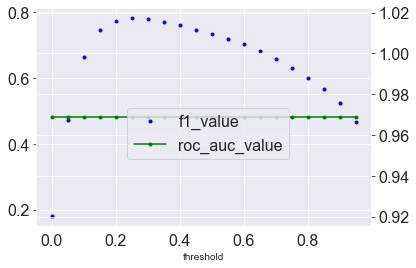

,threshold,f1_value,roc_auc_value
5,0.250000,0.782,0.969
6,0.300000,0.779,0.969
4,0.200000,0.774,0.969
7,0.350000,0.771,0.969
8,0.400000,0.761,0.969
3,0.150000,0.746,0.969
9,0.450000,0.746,0.969
10,0.500000,0.733,0.969
11,0.550000,0.720,0.969
12,0.600000,0.704,0.969


Wall time: 20.6 s


In [24]:
%%time
my_lr_model(tf_idf_train, y_train, 
            tf_idf_test, y_test, 
            class_weight=None)

**С помощью логистической регрессии на базе TF-IDF признаков при базовом пороге в 0.5 получаем F1-метрику 0.73, что не дотягивает до требуемых 0.75. При подборе порога наилучший результат достигается F1-метрики в 0.78 достигается при threshold равным 0.25. Т.е. на модерацию пойдет большее число комментариев, но зато меньше вероятность, что токсичный коммент будет висеть на странице магазина.**

**Здесь, конечно, нужен искать баланс вдруг модераторы не справятся с таким количеством комментриев, и тогда можно немного пожертвовать качеством модели, поставить порог повыше при этом не опускаясь ниже F1-метрики в 0.75.**

## TF-IDF с N-граммами
Попробуем TF-IDF и его N-граммы.

In [25]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords, ngram_range=(1,2))

In [26]:
%%time
tf_idf_train = count_tf_idf.fit_transform(corpus_train) # fit только на обучающей!
tf_idf_test = count_tf_idf.transform(corpus_test)

Wall time: 25.3 s


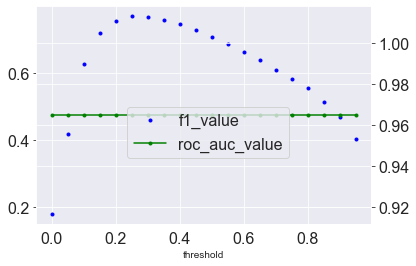

,threshold,f1_value,roc_auc_value
5,0.250000,0.769,0.965
6,0.300000,0.767,0.965
7,0.350000,0.758,0.965
4,0.200000,0.756,0.965
8,0.400000,0.745,0.965
9,0.450000,0.729,0.965
3,0.150000,0.721,0.965
10,0.500000,0.708,0.965
11,0.550000,0.686,0.965
12,0.600000,0.662,0.965


Wall time: 1min 16s


In [27]:
%%time
my_lr_model(tf_idf_train, y_train, 
            tf_idf_test, y_test, 
            class_weight=None)

**Для логистической регрессии на базе TF-IDF и N-грамм при аналогичном пороге в 0.25 имеем качество модели F1 равным 0.77.**

**Т.е. чуть хуже и при этом модель учится ~ в 4 раза дольше (для моего компа без N-грамм заняло 21 секунду, с N-граммами - 76 секунд).**

# SGDClassifier
<font color=blue> Градиентый спуск попробовал ради интереса, еще попробую его улучшить как [описано здесь](https://towardsdatascience.com/how-to-make-sgd-classifier-perform-as-well-as-logistic-regression-using-parfit-cc10bca2d3c4) </font>

In [41]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [66]:
clf = make_pipeline(StandardScaler(with_mean=False), 
                    SGDClassifier(max_iter=1000, loss='log', penalty='l2',
                                 alpha=0.0001, shuffle=True))

In [67]:
%%time
clf.fit(tf_idf_train, y_train)

predict_test = clf.predict(tf_idf_test)
print('Значение F1-метрики {:.2f}'.format(f1_score(y_test, predict_test)))

Значение F1-метрики 0.48
Wall time: 3.15 s


Очень плохая музыка - [я думал гораздо лучше будет](https://www.youtube.com/watch?v=_LhDRHRq-Es) =)

# Выводы

Итого результаты по качеству как F1-метрики следующие:

| Модель | Значение F1 | Примечание |
|:-|-:|-:|
| TF-IDF <br /> без N-грамм | 0.78 | при пороге 0.25 |
| TF-IDF <br /> с N-граммами| 0.77 | при пороге 0.25  |

Обучение занимает довольно продолжительное время, поэтому еще можно  провести дополнительную очистку, удалить с помощью регулярных выражений всякие '----', повторения букв более двух подряд и т.п.
Также можно попробовать применить техники upsampling или downsampling для выравнивания баланса классов.

Ссылка для себя: [оформление таблиц в markdown](https://www.pluralsight.com/guides/working-tables-github-markdown)